In [19]:
import networkx as nx
import numpy as np
from matplotlib import pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout

from conet.data_converter.corrected_counts import CorrectedCounts
from conet.data_converter.data_converter import DataConverter
from conet import CONET, CONETParameters, InferenceResult
from conet.generative_model import CNSampler, EventTree, CountsGenerator, EventTreeGenerator

bin_dir = "./" # path to dir with CONET executable
loci = 1000
tree_size = 10
cells = 260

In [10]:
# generate event tree and cell data
cn_s = CNSampler.create_default_sampler()
t_gen = EventTreeGenerator(cn_sampler=cn_s, tree_size=tree_size, no_loci=loci)
tree: EventTree = t_gen.generate_random_tree()
d_gen = CountsGenerator(cn_s, tree)
counts, attachment, corrected_counts, brkp_matrix = d_gen.generate_data(loci, cells)

2022-05-20 20:55:02,918 — conet.generative_model.event_tree_generator — INFO — Starting event tree generation...
2022-05-20 20:55:02,919 — conet.generative_model.event_tree_generator — INFO — Sampled size of trunk equal to 2.
2022-05-20 20:55:02,920 — conet.generative_model.event_tree_generator — INFO — Successfully sampled unvalidated event tree structure.
2022-05-20 20:55:02,920 — conet.generative_model.event_tree — INFO — Testing validity of generated tree...
2022-05-20 20:55:02,921 — conet.generative_model.event_tree — INFO — Tree has non-identifiable breakpoint loci. Validation failed.
2022-05-20 20:55:06,901 — conet.generative_model.event_tree_generator — INFO — Starting event tree generation...
2022-05-20 20:55:06,901 — conet.generative_model.event_tree_generator — INFO — Sampled size of trunk equal to 4.
2022-05-20 20:55:06,902 — conet.generative_model.event_tree_generator — INFO — Successfully sampled unvalidated event tree structure.
2022-05-20 20:55:06,903 — conet.generative

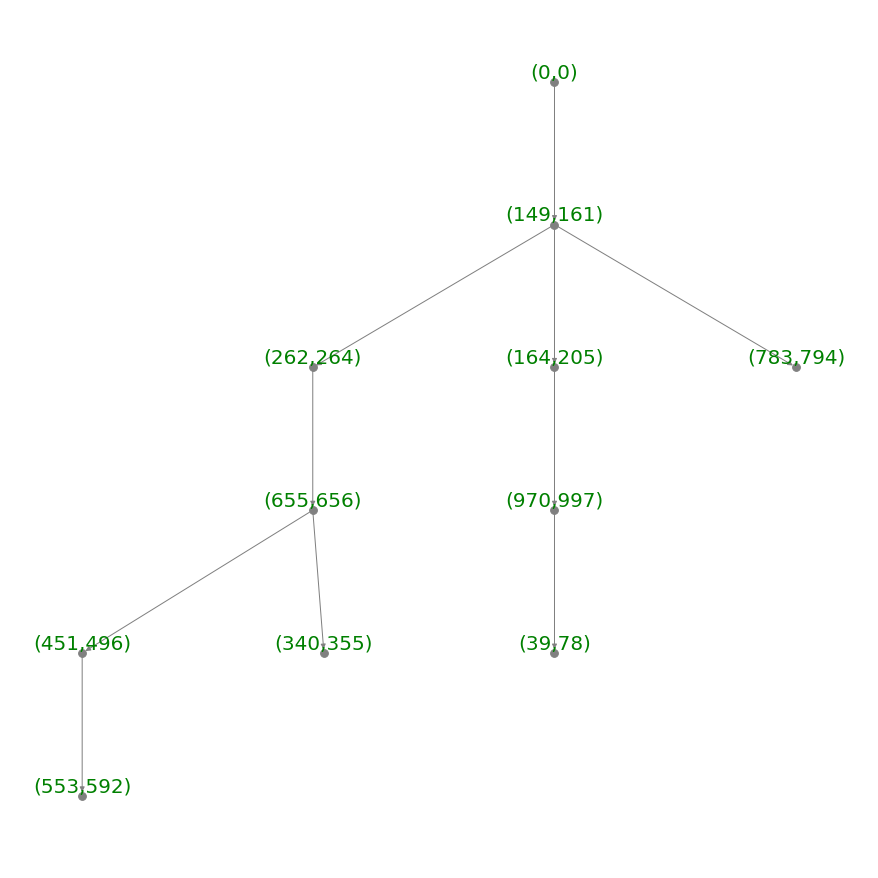

In [12]:
# Draw simulated tree
plt.figure(3, figsize=(12, 12))
pos = graphviz_layout(tree.tree, prog="dot")
nx.draw(tree.tree, pos=pos, with_labels=True, node_color="grey", node_size=60, verticalalignment="bottom",
        font_size=20, edge_color="grey", font_color="green")
plt.show()

In [13]:
# Convert corrected counts dataframe to input files for CONET 
cc = CorrectedCounts(corrected_counts)
DataConverter(event_length_normalizer=loci).create_CoNET_input_files(out_path=bin_dir, corrected_counts=cc)

In [14]:
# Run CONET
conet = CONET(bin_dir + "CONET")
params = CONETParameters(tree_structure_prior_k1=0.5, data_dir=bin_dir, counts_penalty_s1=100000,
                         counts_penalty_s2=100000,
                         param_inf_iters=200000, seed=2167, mixture_size=2, pt_inf_iters=500000,
                         use_event_lengths_in_attachment=False,
                         event_length_penalty_k0=1, output_dir = "./output/")
conet.infer_tree(params)

b''


In [15]:
result = InferenceResult('./output/', cc)

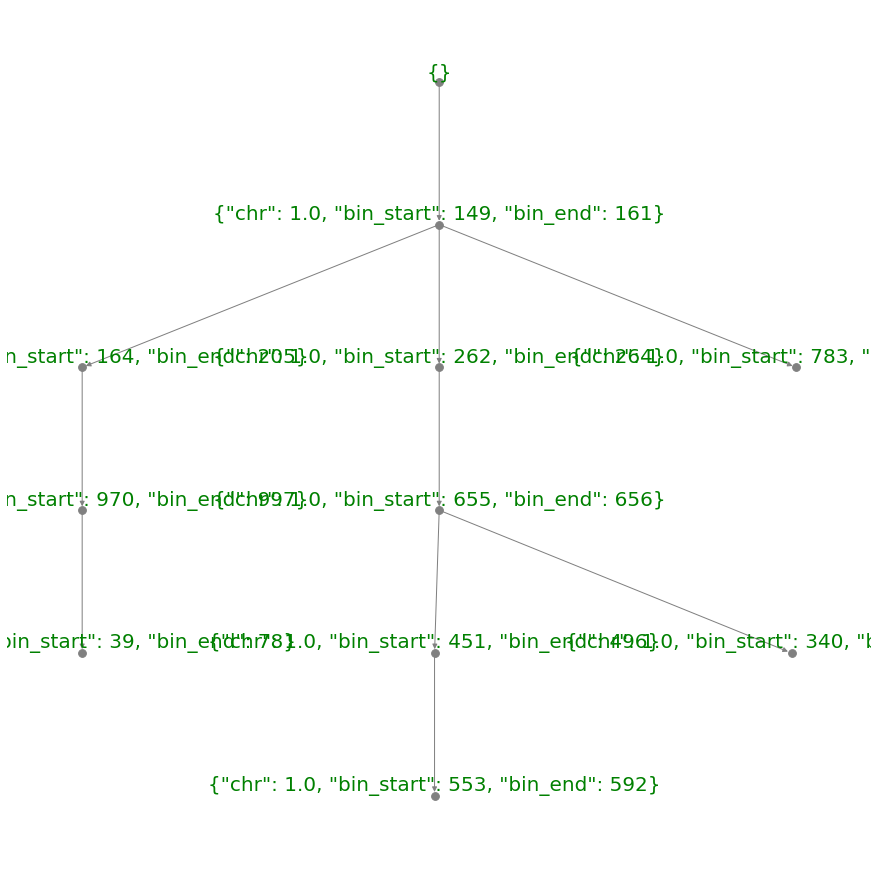

In [16]:
# Draw inferred tree 
plt.figure(3, figsize=(12, 12))
pos = graphviz_layout(result.inferred_tree, prog="dot")
nx.draw(result.inferred_tree, pos=pos, with_labels=True, node_color="grey", node_size=60, verticalalignment="bottom",
        font_size=20, edge_color="grey", font_color="green")
plt.show()

In [20]:
# Additionally one can compare estimated and real copy number profiles... 
inferred_counts = np.transpose(result.get_inferred_copy_number(neutral_cn=2))
real_counts = counts